In [ ]:
import sys
import os
import shutil
import warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import tensorflow as tf
import tensorflow.keras as keras

from keras import Input, Model
from keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

from skimage.feature import peak_local_max

from matplotlib.patches import Rectangle

import cv2

sns.set_style('darkgrid')

warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import random

def seed_all(value=42):
    random.seed(value)
    np.random.seed(value)
    tf.random.set_seed(value)
    os.environ['PYTHONHASHSEED'] = str(value)
#     os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_all(1)

In [ ]:
from google.colab import files

# Upload a file
uploaded = files.upload()
for file_name in uploaded.keys():
    print(f"Uploaded file: {file_name}")


Detected MIME type: application/zip


In [ ]:
import zipfile


zip_file_name = 'archivetrain2.zip'
extract_dir = 'extracted_images'


os.makedirs(extract_dir, exist_ok=True)


try:
    with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Extracted files to {extract_dir}")
except zipfile.BadZipFile:
    print(f"Error: The file {zip_file_name} is not a ZIP file or it is corrupted.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Extracted files to extracted_images


In [ ]:
import glob


image_paths = glob.glob(os.path.join(extract_dir, '*.png'))

from tensorflow.keras.preprocessing.image import load_img, img_to_array


images = [img_to_array(load_img(img_path, target_size=(224, 224))) / 255.0 for img_path in image_paths]


In [ ]:
IMAGE_ROOT  = "/content/extracted_images/head_ct/head_ct"
LABELS_FILE = "/content/extracted_images/labels.csv"

LABELS = ['NORMAL', 'HEMORRHAGE']

# IMAGE_SIZE = (256, 256)
IMAGE_SIZE = (128, 128)

In [ ]:
labels = pd.read_csv(LABELS_FILE, names=['id', 'hemorrhage'], header=0)
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   id          200 non-null    int64
 1   hemorrhage  200 non-null    int64
dtypes: int64(2)
memory usage: 3.2 KB


SAMPLE IMAGES

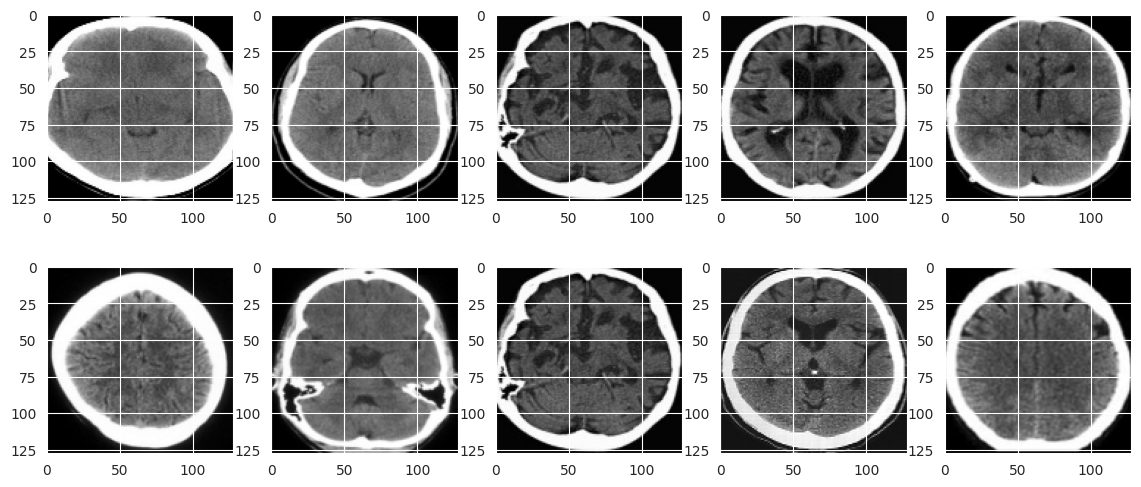

In [ ]:
samples = x[y_class[:, 0] == 1]

rows, cols = 2, 5
fig=plt.figure(figsize=(14, 6))
for i in range(1, rows*cols+1):
    fig.add_subplot(rows, cols, i)
    image = samples[random.randrange(samples.shape[0])]
    plt.imshow(image, cmap='gray')
plt.show()

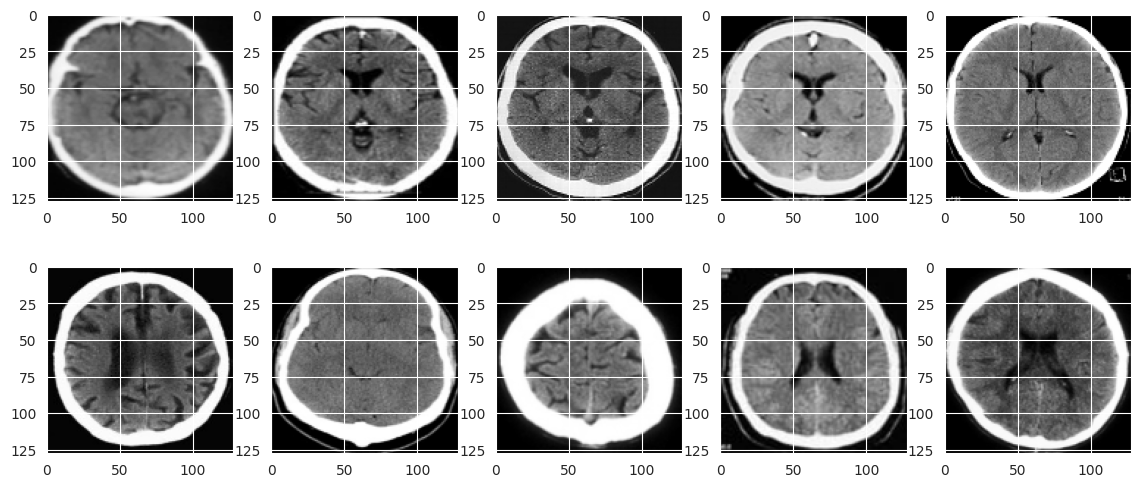

SAMPLE IMAGES OF BRAIN HAEMORRHAGE

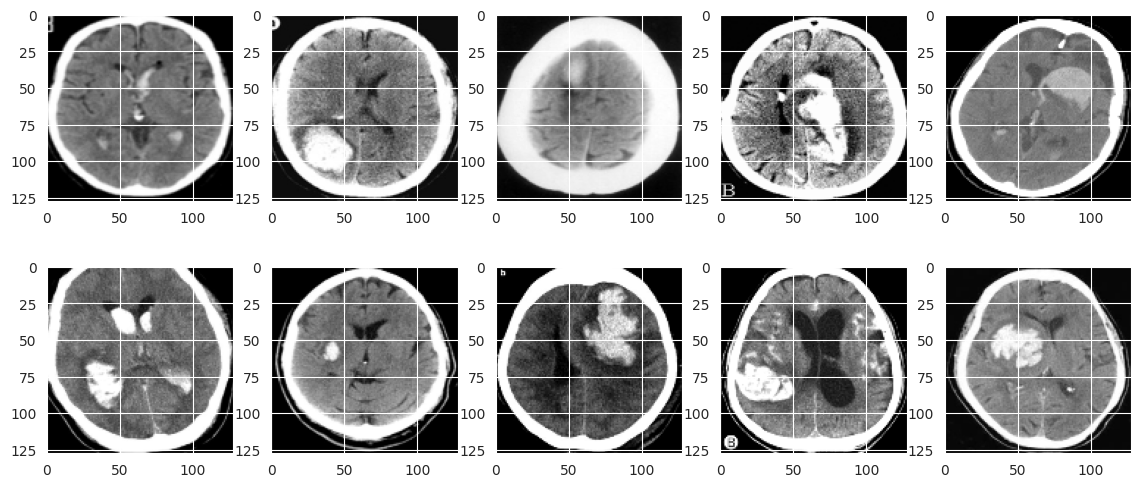

In [ ]:
samples = x[y_class[:, 1] == 1]

rows, cols = 2, 5
fig=plt.figure(figsize=(14, 6))
for i in range(1, rows*cols+1):
    fig.add_subplot(rows, cols, i)
    image = samples[random.randrange(samples.shape[0])]
    plt.imshow(image, cmap='gray')
plt.show()

MODEL TRAINING :


In [ ]:
data_augmentation = keras.Sequential([
        layers.Normalization(),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.2),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
], name="data_augmentation")

data_augmentation.layers[0].adapt(x)

In [ ]:
def create_model(X_shape, classes=2, name="HemorrhageDetectionModel"):

    def conv_block(x, filters, *, kernels=None, steps=None, pooling=True, name=""):
        for i in range(len(filters)):
            x = layers.Conv2D(filters[i], kernels[i] if kernels else (3, 3),
                              strides=steps[i] if steps else (1, 1),
                              padding='same', name=f'{name}_conv_{i}')(x)
            x = layers.BatchNormalization(name=f'{name}_norm_{i}')(x)
            x = layers.Activation('relu', name=f'{name}_relu_{i}')(x)
        if pooling:
            x = layers.MaxPooling2D((2, 2), name=f'{name}_maxpool')(x)
        return x

    inputs = x = Input(X_shape[-3:], name='inputs')

    # Convolutional blocks
    x = conv_block(x, (64, 64), name="block_1")
    x = conv_block(x, (128, 128), name="block_2")
    x = conv_block(x, (256, 256), name="block_3")
    x = conv_block(x, (512, 512), pooling=False, name="block_4")

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x)

    # Classification output (for 2 classes)
    classification_output = layers.Dense(classes, activation='softmax', name='classification_output')(x)

    # Return the model with only classification output
    return Model(inputs=inputs, outputs=classification_output, name=name)


In [ ]:
EPOCHS = 100
BATCH_SIZE = 16

# Assuming the create_model function returns a model with only one output now (classification output)
model = create_model(x.shape, 2)

# Compiling the model with just classification output
model.compile(optimizer="adam",
              loss='categorical_crossentropy',  # Only for classification
              metrics=['accuracy'])  # Only classification accuracy is needed

model.summary(expand_nested=True)

# Ensuring the directory for checkpoints exists
checkpoint_dir = "/content/model"
os.makedirs(checkpoint_dir, exist_ok=True)

# Defining the path for the model checkpoint
MODEL_CHECKPOINT = f"{checkpoint_dir}/{model.name}.keras"

# Defining the callbacks
callbacks_list = [
    keras.callbacks.ModelCheckpoint(filepath=MODEL_CHECKPOINT, monitor='loss', save_best_only=True, mode='min', verbose=1)
]

# Training the model
history = model.fit(x=x,
                    y=y_class,  # Only classification labels are passed
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks_list,
                    verbose=1)

# Loading the best weights after training
model.load_weights(MODEL_CHECKPOINT)


Model: "HemorrhageDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 128, 128, 1)]     0         
                                                                 
 block_1_conv_0 (Conv2D)     (None, 128, 128, 64)      640       
                                                                 
 block_1_norm_0 (BatchNorma  (None, 128, 128, 64)      256       
 lization)                                                       
                                                                 
 block_1_relu_0 (Activation  (None, 128, 128, 64)      0         
 )                                                               
                                                                 
 block_1_conv_1 (Conv2D)     (None, 128, 128, 64)      36928     
                                                                 
 block_1_norm_1 (BatchNorma  (None, 128, 1

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def preprocess_image(image_path):
    # Loading the image and converting it to grayscale
    image = load_img(image_path, target_size=(128, 128), color_mode='grayscale')

    # Converting the image to a numpy array and normalizing pixel values
    image = img_to_array(image) / 255.0

    # Adding a batch dimension in (None, 128, 128, 1)
    image = np.expand_dims(image, axis=0)

    return image


In [ ]:
# Loading and preprocessing the new image
new_image_path = "/content/0f29d6f005e4ecd095ab274d86afbafb07edbdc27e8f6509eb01946851abeb11_big_gallery.png"
preprocessed_image = preprocess_image(new_image_path)

# Predicting using the model
class_probs = model.predict(preprocessed_image)

# results
print("Class probabilities:", class_probs)


1/1 [==============================] - 1s 922ms/step
Class probabilities: [[0.0052661 0.9947339]]


In [ ]:
# Saving the entire model as a .h5 file
model.save("hemorrhage_detection_model.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model

# Load the model from .h5 file
model = load_model("hemorrhage_detection_model.h5")



In [ ]:
import joblib

# Saving other objects like preprocessing pipeline
preprocessing_steps = {"image_size": (128, 128)}
joblib.dump(preprocessing_steps, "preprocessing_steps.joblib")

# To load it later
loaded_steps = joblib.load("preprocessing_steps.joblib")
print(loaded_steps)



{'image_size': (128, 128)}


In [ ]:
files.download('hemorrhage_detection_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>